In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import subprocess
import time
import pandas
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import scipy.io as sio
from scipy import interpolate
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.patches as mpatches
import sys
import re
import random
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(suppress=True)


In [3]:
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging ###RAW FRAMERATE
averagedframerate = timebetweenframes/frameaveraging ###AVERAGED FRAMERATE

def analyze_single_session(indir, window_size, pre_window_size):
        
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']
    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and not 'results' in f and not 'part2' in f and not 'part3' in f and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numrois = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        signals = np.hstack((signals, signals2))

        
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)
        
        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
        
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        signals = np.hstack((signals, signals3))
        
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        
        
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        signals = np.hstack((signals, signals4))
        
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        
        
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    
    
    ###THIS SECTION DEFINES CERTAIN INPUTS IN EVENTLOG AS BEHAVIORAL STIMULI (LEVER PRESS, CUE, ETC)
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]
    
#     print(activelever.shape, '=activelever')
#     print(activelevertimeout.shape,'=activelevertimeout')
    
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
        
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    
    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i])
        activelever=included_trials
#         print ('The behavioral file is longer than the imaging file. We discarded n = ', len(discarded_trials), ' active lever presses')
#         print ('and included n = ', len(included_trials), ' active lever presses')   
        
#     signals /= np.nanmean(signals, axis=1)[:, None]
#     signalsT = signals.T    
    
    ###COMBINES ALL PRESSES
    activeleverall = np.hstack((activelever, activelevertimeout))
#     activeleverall = activelever ###UNCOMMENT TO LOOK AT CUE-REINFORCED TRIALS ONLY
#     activeleverall = activelevertimeout ###UNCOMMENT TO LOOK AT CUE-NONREINFORCED TRIALS ONLY
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))
    print(activeleverall.shape)
#     if activeleverall.shape[0] < 10:
#         activeleverall = np.array([])
#         print('<10 presses, data excluded')
#     if inactiveleverall.shape[0] < 10:
#         activeleverall = np.array([])
#         print('<10 presses, data excluded')
    
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numrois])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numrois])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])

        #align_to_plot is made in such a way that for every trial, only frames that have not been plotted
        # in the previous trial are plotted. So if the previous trial's post_window_size-th frame after
        # origin is after this trial's pre_window_size-th frame before origin, then the overlapping frames
        # are stored as nan.
            
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                else:
                    endindex = tempendindex.astype(int)  
                prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numrois))
                    align[i,:,:] = np.nan*np.ones((window_size, numrois))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))

        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0,0]))[0],:,:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
            
        return align, align_to_plot, framenumberfor_eventofinterest

    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  ###CHANGE LAST VARIABLE TO CHANGE EXTRACTED INFO
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
    


# print shape(populationdata_activelever) if populationdata_activelever = \
#         nan np.isnan() method  #To check for NaN values in a Numpy array you can use the np. isnan() method. This outputs a boolean mask of the size that of the original array. The output array has true for the indices which are NaNs in the original array and false for the rest.
#         import pandas as pd. x = float("nan") print(f"It's pd.isna : { pd.isna(x) }")OutputIt's pd.isna : True.
#         import numpy as np. x = float("nan") print(f"It's np.isnan : { np.isnan(x) }")OutputIt's np.isnan : True.
#         import math. x = float("nan")
    
    
#     align_activelevertimeout, align_to_plot_activelevertimeout, framenumberfor_frameafter_activelevertimeout = calculate_aligneddata_forevent(signalsT,
#                                                                                                                 activelevertimeout)

#     aligned_alltrials, aligned_to_plot_alltrials, framenumberfor_firstlickafteralltrials = calculate_aligneddata_forevent(signalsT, cues)  ###Added to save aligned_to_trial.npy for decoding
#     np.save(os.path.join(indir,'aligned to trial.npy'), aligned_alltrials)  ###TO SAVE 'aligned to trial.npy' FOR DECODING
    
    
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
#     populationdata_activelevertimeout = np.nanmean(align_activelevertimeout, axis=0).T-1
        
#     return populationdata_activelever, populationdata_activelevertimeout, align_activelever, align_activelevertimeout, framerate
    return populationdata_activelever, populationdata_activelever, align_activelever, align_activelever, framerate


    ###NOTE:  populationdata_sucrose is CS+ responses for each neuron, averaged across trials (2 dimensional). Used for population heat maps.
    ###NOTE:  align_sucrose is the same, but not averaged across trials (3 dimensional). Use for PieCharts and individual cell responses.

    
###OTHER FUNCTIONS
def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [4]:
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)


    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

###Artifically inserts frames timestamps from prior datasets

behaviordata_noframes = sio.loadmat\
    (r'/Users/jamesotis/Dropbox/2P Imaging Projects/Beth/PFC Self Admin Analysis/Codes/matfile_noframes_3.mat')
#     (r'C:\Users\OtisLab\Dropbox\2P Imaging Projects\Beth\PFC Self Admin\Codes\matfile_noframes_3.mat')
#     (r'/Users/otisl/Dropbox/2P Imaging Projects/Beth/PFC Self Admin/Codes/matfile_noframes_self ad.mat')
eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

max_of_eventlog_noframes = max(eventlog_noframes[:,1])
length_of_eventlog_noframes = len(eventlog_noframes[:,1])
x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)

eventlog_noframes = x

###Provides about 4.32 hours worth of frames if 4 frame averaging)
assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO


No Cell Tracking
Early CTL1 FOV1
(30,)
Early ER-L1 FOV1
(28,)
Early ER-L2 FOV1
(148,)
Early LCDD-PGa1 FOV1
(87,)
Early LCDD-PGa4 FOV1
(18,)
Early LCDD-PGa6 FOV1
(120,)
Early LCDD-PGa-T1 FOV1
(159,)
Early LCDD-PGa-T3 FOV1
(24,)
Early LCDD-PGa-T4 FOV1
(48,)
Early PGa-T1 FOV1
(11,)
Early PGa-T2 FOV1
(18,)
Early PGa-T3 FOV1
(7,)
Middle LCDD-PGa1 FOV1
(6,)
Middle LCDD-PGa5 FOV1
(6,)
Middle LCDD-PGa-T2 FOV1
(4,)
Middle LCDD-PGa-T3 FOV1
(7,)
Middle PGa-T1 FOV1
(7,)
Middle PGa-T2 FOV1
(6,)


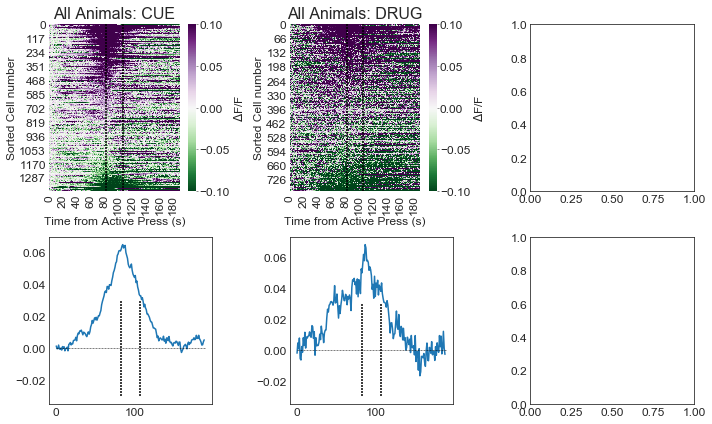

In [54]:
### POPULATION ANALYSIS

### DO YOU WISH TO DO SINGLE CELL TRACKING?
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes

#select your tracking CSV IDs if you're doing tracking. Comment out the other.
# csv_id_for_tracking = 'SCT-ScramControl'
csv_id_for_tracking = 'CUE-DRUG-TMT'


### ACQUISITION IF RUNNING FROM JIM'S MACBOOK PRO
basedir = r'/Users/jamesotis/Dropbox/2P Imaging Projects/Beth/PFC Self Admin Analysis'
earlybasedir = r'/Users/jamesotis/Dropbox/2P Imaging Projects/Beth/PFC Self Admin Analysis/EarlyExt'
middlebasedir = r'/Users/jamesotis/Dropbox/2P Imaging Projects/Beth/PFC Self Admin Analysis/LastExt'
# latebasedir = r'/Users/jamesotis/Dropbox/2P Imaging Projects/Beth/PFC Self Admin Analysis/LateAcq'

###FOR EARLY EXTINCTION, IG-19 PRESSED 0 TIMES, and LCDD-PGa-T2, LCDD-PGa-T5, LCDD-PGa3, LCDD-PGa5 PRESSED 1 TIME. 
###FOR LAST EXTINCTION, CTL1, ER-L2, IG-19, LCDD-PGa-T1, LCDD-PGa3, LCDD-PGa4, PGa-T3 PRESSED 0 TIMES, LCDD-PGa6 PRESSED 1 TIME. 
###FOR LAST EXTINCTION ER-L1, , LCDD-PGA-T4, LCDD-PGA-T5 had 3 presses and out

###ACQUSITION ALL MICE OF INTEREST 
early_animals_of_interest = ['CTL1','ER-L1','ER-L2','LCDD-PGa1','LCDD-PGa4','LCDD-PGa6','LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4','PGa-T1','PGa-T2','PGa-T3']  
middle_animals_of_interest = ['LCDD-PGa1','LCDD-PGa5','LCDD-PGa-T2','LCDD-PGa-T3','PGa-T1','PGa-T2']


#LCDD-PGa3 didn't press much during reinstatement
#LCDD-PGa5 has no DRUG OR TMT Rein

### PICK THE FRAMES THAT YOU WANT TO BE PLOTTED
pre_window_size = int(10*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))

### FIGURE SETTINGS
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
sns.set_style('white')

cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax


###TRACKING ARRAYS
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')
    
###THIS IS FOR EARLY SESSIONS
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))

for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        print('Early', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(earlybasedir, animal, fov),
                                                            window_size, pre_window_size)
        
        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        numneurons=populationdata_active_population.shape[0]
        
        if tracking == 'Yes' and 'tracked' in fov:
            tempfiles = next(os.walk(os.path.join(earlybasedir, animal, fov)))[2]  
            roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
                        and csv_id_for_tracking in f][0]
            roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(earlybasedir,\
                        animal, fov, roi_csvfile), delimiter = ',', unpack=True)
            active_population_temp = np.nan*np.ones((len(roi_early_list), window_size))
            for i in range(len(roi_early_list)):
                active_population_temp[i,:] = temp1[(int(roi_early_list[i]-1)),:]
            population_active_tracked_early = np.vstack((population_active_tracked_early, active_population_temp))

        
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

if tracking == 'Yes':
    population_active_tracked_early = population_active_tracked_early[1:,:]
    populationdata_active_population = population_active_tracked_early
    
baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_early = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early = np.argsort(tempresponse)[::-1]

ax = axs[0,0]

if sorting == 'Yes':
    sns.heatmap(pop_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
               cbar_kws={'label': '$\Delta$F/F'})
else:
    sns.heatmap(pop_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
               cbar_kws={'label': '$\Delta$F/F'})
ax.grid(False)
ax.set_title('All Animals: CUE')
ax.set_ylabel('Sorted Cell number')
ax.set_xlabel('Time from Active Press (s)')
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_early], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_early], '--k', linewidth=1.5) 

ax = axs[1,0]
ax.plot(np.mean(pop_active, axis = 0))
ax.plot([pre_window_size, pre_window_size],
         [-.03,.03],'--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [-.03,.03], '--k', linewidth=1.5) 
ax.plot([0, window_size],
        [0,0], '--k', linewidth=0.5) 

early_active = pop_active



###THIS IS FOR MIDDLE SESSIONS
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))


for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        print('Middle', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(middlebasedir, animal, fov),
                                                            window_size, pre_window_size)

        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        numneurons=populationdata_active_population.shape[0]

        
        if tracking == 'Yes' and 'tracked' in fov:
            tempfiles = next(os.walk(os.path.join(middlebasedir, animal, fov)))[2]  
            roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
                           and csv_id_for_tracking in f][0]
            roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(middlebasedir,\
                        animal, fov, roi_csvfile), delimiter = ',', unpack=True)
            active_population_temp = np.nan*np.ones((len(roi_middle_list), window_size))
            
            for i in range(len(roi_middle_list)):
                active_population_temp[i,:] = temp1[(int(roi_middle_list[i]-1)),:]
            population_active_tracked_middle = np.vstack((population_active_tracked_middle, active_population_temp))

        
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

if tracking == 'Yes':
    population_active_tracked_middle = population_active_tracked_middle[1:,:]
    populationdata_active_population = population_active_tracked_middle

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_middle = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle = np.argsort(tempresponse)[::-1]

ax = axs[0,1]
if sorting == 'Yes' and sorttoearly =='No':
    sns.heatmap(pop_active[sortresponse_middle,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
               cbar_kws={'label': '$\Delta$F/F'})
elif sorting == 'Yes' and sorttoearly =='Yes':
    sns.heatmap(pop_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
               cbar_kws={'label': '$\Delta$F/F'})
else:
    sns.heatmap(pop_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
               cbar_kws={'label': '$\Delta$F/F'})
ax.grid(False)
ax.set_title('All Animals: DRUG')
ax.set_ylabel('Sorted Cell number')
ax.set_xlabel('Time from Active Press (s)')
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_middle], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_middle], '--k', linewidth=1.5) 

ax = axs[1,1]
ax.plot(np.mean(pop_active, axis = 0))
ax.plot([pre_window_size, pre_window_size],
         [-.03,.03],'--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [-.03,.03], '--k', linewidth=1.5) 
ax.plot([0, window_size],
        [0,0], '--k', linewidth=0.5) 

middle_active = pop_active

# ###THIS IS FOR LATE SESSIONS
# # populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
# # populationdata_inactive_population = np.nan*np.ones((1, window_size))

# # for animal in late_animals_of_interest:
# #     FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
# #     for fov in sorted(FOVs):
# #         print('Late', animal, fov)
# #         temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(latebasedir, animal, fov),
# #                                                             window_size, pre_window_size)
        
# #         populationdata_active_population = np.vstack((populationdata_active_population, temp1))
# #         populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

# #         numneurons=populationdata_active_population.shape[0]
        
# #         if tracking == 'Yes' and 'tracked' in fov:
# #             tempfiles = next(os.walk(os.path.join(latebasedir, animal, fov)))[2]  
# #             roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
# #                            and csv_id_for_tracking in f][0]
# #             roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(latebasedir,\
# #                         animal, fov, roi_csvfile), delimiter = ',', unpack=True)
# #             active_population_temp = np.nan*np.ones((len(roi_late_list), window_size))
# #             for i in range(len(roi_late_list)):
# #                 active_population_temp[i,:] = temp1[(int(roi_late_list[i]-1)),:]
# #             population_active_tracked_late = np.vstack((population_active_tracked_late, active_population_temp))

        
# # populationdata_active_population = populationdata_active_population[1:,:]
# # populationdata_inactive_population = populationdata_inactive_population[1:,:]

# # if tracking == 'Yes':
# #     population_active_tracked_late = population_active_tracked_late[1:,:]
# #     populationdata_active_population = population_active_tracked_late


# # baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
# # pop_active = populationdata_active_population - baseline[:,None]
# # baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
# # pop_inactive = populationdata_inactive_population - baseline[:,None]
# # numrois_late = pop_active.shape[0]
# # tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
# # sortresponse_late = np.argsort(tempresponse)[::-1]

# # ax = axs[0,2]
# # if sorting == 'Yes' and sorttoearly =='No':
# #     sns.heatmap(pop_active[sortresponse_late,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
# #                cbar_kws={'label': '$\Delta$F/F'})
# # elif sorting == 'Yes' and sorttoearly =='Yes':
# #     sns.heatmap(pop_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
# #                cbar_kws={'label': '$\Delta$F/F'})
# # else:
# #     sns.heatmap(pop_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
# #                cbar_kws={'label': '$\Delta$F/F'})
# # ax.grid(False)
# # ax.set_title('All Animals: TMT')
# # ax.set_ylabel('Sorted Cell number')
# # ax.set_xlabel('Time from Active Press (s)')
# # ax.plot([pre_window_size, pre_window_size],
# #         [0, numrois_late], '--k', linewidth=1.5)
# # ax.plot([infusionframe, infusionframe],
# #         [0, numrois_late], '--k', linewidth=1.5) 

# # ax = axs[1,2]
# # ax.plot(np.mean(pop_active, axis = 0))
# # ax.plot([pre_window_size, pre_window_size],
# #          [-.03,.03],'--k', linewidth=1.5)
# # ax.plot([infusionframe, infusionframe],
# #         [-.03,.03], '--k', linewidth=1.5)
# # ax.plot([0, window_size],
# #         [0,0], '--k', linewidth=0.5) 

# # late_active = pop_active
fig.tight_layout()
fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Heatmaps.PNG'), format='PNG')

In [60]:
### COMBINE EARLY, MIDDLE, AND LATE FOR CLUSTERING
### ONLY RUN IF YOU WANT TO COMBINE DATA ACROSS TESTS

new_active = np.vstack((early_active, middle_active))
print(new_active.shape)


(2184, 190)


# CLUSTERING: ONLY USE THIS SECTION IF YOU WANT TO REDO CLUSTERING!

In [61]:
###CLUSTERING STARTS HERE
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

In [62]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3, 
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

In [63]:
populationdata = new_active ###SELECT data that you want to analyze 

###early_active is first set in population activity, middle_active is second, and late_active is third)
###new_active combines them all

print (populationdata.shape, 'array for clustering')

numneurons = populationdata.shape[0]
populationdata_nan_excluded = np.nan*np.ones((1, window_size))

for i in range(numneurons):
    if np.mean(populationdata[i]) < 1000:
        populationdata_nan_excluded = np.vstack((populationdata_nan_excluded,populationdata[i]))
populationdata_nan_excluded = populationdata_nan_excluded[1:,:]
if np.shape(populationdata) != np.shape(populationdata_nan_excluded):
    print ('NaNs were deleted, the variable "populationdata" has been updated')
    print (populationdata.shape, 'array without NaN neurons')
    
    
sortwindow = [pre_window_size, infusionframe] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]

# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['Active']
    

(2184, 190) array for clustering


/Users/jamesotis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(2184, 73)


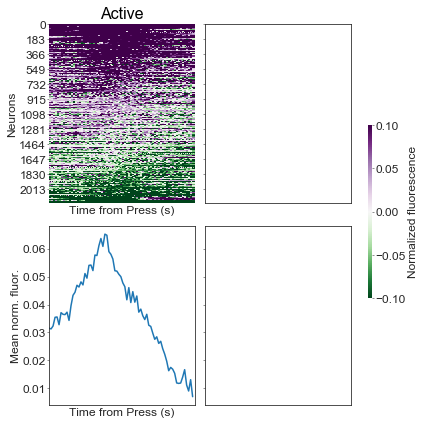

In [64]:
populationdata = populationdata[:,pre_window_size - int(3*framerate): pre_window_size + int(6*framerate)]

fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('PRGn_r'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    
        
    ax = axs[1,t]
    sns.lineplot(data=np.mean(populationdata[sortresponse, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
#     ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
#     ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    ax.set_xticks([])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')


fig.tight_layout()
fig.subplots_adjust(right=0.82)

print(populationdata.shape)


Number of PCs = 73
[66.22497003 10.88325078  2.81334984  0.94158823  0.77133778  0.58708038
  0.57397593  0.53784998  0.50240517  0.47160119  0.45598309  0.43909205
  0.41661765  0.39732251  0.38845053  0.38250071  0.37658329  0.37131409
  0.36355531  0.35726391  0.34755337  0.33623373  0.32139439  0.31694111
  0.31056459  0.30538428  0.30386779  0.29758313  0.29333634  0.28773187
  0.28149325  0.2789093   0.27519397  0.26846556  0.26625683  0.25827527
  0.25531813  0.25176331  0.2496558   0.23922618  0.23451304  0.23196425
  0.22940464  0.2281533   0.2246058   0.22101741  0.21625651  0.2130157
  0.21032287  0.20502193  0.20092074  0.19997423  0.19601751  0.19169279
  0.18930911  0.18632569  0.18104072  0.17879176  0.17662549  0.17389835
  0.16831082  0.1641952   0.15896115  0.1582712   0.15688909  0.15059207
  0.14633913  0.1415768   0.1410535   0.13835596  0.13334423  0.13079096
  0.12120743]
Number of PCs to keep = 3


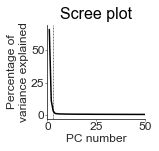

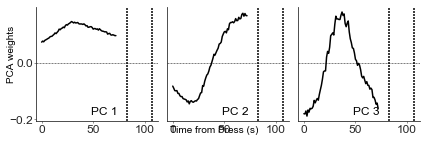

In [65]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'Results','PFC_SA_pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'Results','PFC_SA_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
np.save(os.path.join(basedir, 'Results', 'PFC_SA_transformed_data.npy'), transformed_data)
transformed_data = np.load(os.path.join(basedir,'Results', 'PFC_SA_transformed_data.npy'))

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print(x)
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['Active'] = (0,0,0) 
# colors_for_key['Inactive'] = (0.5,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    ax.axvline(pre_window_size+int(framerate*3), linestyle='--', color='k', linewidth=1.5)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
    ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
                textcoords='axes fraction', multialignment='center', size='large')
#     if pc >= num_retained_pcs-numcols:
#         ax.set_xticks([0, pre_window_size,
#                        infusionframe, window_size])
#         ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                              for a in [0, pre_window_size,
#                                        infusionframe, window_size]])
#     else:
#         ax.set_xticks([])
#         ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction PCs.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction PCs.png'), format='PNG')


In [67]:
max_n_clusters = 5 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([250, 750, 1300, 1700, 2000]) # This should be selected for each dataset
# appropriately. When 1511 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir,'Results', 'PFC_SA_silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)   
    

Done with numclusters = 2, num nearest neighbors = 250: score = 0.401
Done with numclusters = 2, num nearest neighbors = 750: score = 0.409
Done with numclusters = 2, num nearest neighbors = 1300: score = 0.328
Done with numclusters = 2, num nearest neighbors = 1700: score = 0.198
Done with numclusters = 2, num nearest neighbors = 2000: score = 0.101
Done with numclusters = 3, num nearest neighbors = 250: score = 0.435
Done with numclusters = 3, num nearest neighbors = 750: score = 0.442
Done with numclusters = 3, num nearest neighbors = 1300: score = 0.327
Done with numclusters = 3, num nearest neighbors = 1700: score = 0.093
Done with numclusters = 3, num nearest neighbors = 2000: score = -0.107
Done with numclusters = 4, num nearest neighbors = 250: score = 0.438
Done with numclusters = 4, num nearest neighbors = 750: score = 0.465
Done with numclusters = 4, num nearest neighbors = 1300: score = 0.242
Done with numclusters = 4, num nearest neighbors = 1700: score = 0.023
Done with n

In [68]:
with open(os.path.join(basedir, 'Results','PFC_SA_silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# transformed_data = np.load(os.path.join(earlybasedir, 'PFC_SA_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters, algorithm = 'elkan')

# model = AgglomerativeClustering(n_clusters=n_clusters)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
with open(os.path.join(basedir, 'Results', 'PFC_SA_clusteringmodel.pickle'), 'wb') as f:
    pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))


colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

np.save(os.path.join(basedir, 'Results', 'PFC_SA_clusterlabels.npy'), newlabels)
##ONLY USE IF YOU WANT TO OVERWRITE EXISTING, SAVED CLUSTERING DATA

4 750
Number of clusters = 4, average silhouette = 0.466


/Users/jamesotis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jamesotis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Silhouettes.PDF'), format='PDF')
    fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Silhouettes.PNG'), format='PNG')

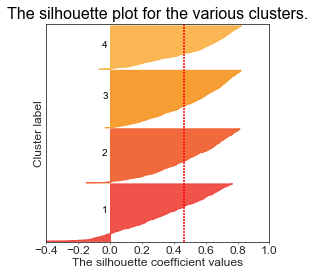

In [70]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)


In [71]:
####This section saves cluster IDs to each FOV Folder for future use. 
####DO NOT RUN/SAVE UNLESS YOU WANT TO OVERWRITE CLUSTER LISTS

cluster_id_list = newlabels

cellcounter = 0

##Assign cluster IDs to neurons within [early] animals of interest
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(earlybasedir, animal, fov),
                                                                window_size, pre_window_size)
        numneurons = temp3.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        np.save(os.path.join(earlybasedir, animal, fov, fov+'_cluster_list_per_fov_Extinction.npy'), neuron_id_list)
firstcellearly = 0
lastcellearly = cellcounter
np.save(os.path.join(earlybasedir, 'cluster_list_per_session_Extinction.npy'), newlabels[firstcellearly:lastcellearly])
print(newlabels[firstcellearly:lastcellearly].shape)


##Assign cluster IDs to neurons within [early] animals of interest
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(middlebasedir, animal, fov),
                                                                window_size, pre_window_size)
        numneurons = temp3.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        np.save(os.path.join(middlebasedir, animal, fov, fov+'_cluster_list_per_fov_Extinction.npy'), neuron_id_list)
firstcellmiddle = lastcellearly
lastcellmiddle = cellcounter

np.save(os.path.join(middlebasedir, 'cluster_list_per_session_Extinction.npy'), newlabels[firstcellmiddle:lastcellmiddle])
print(newlabels[firstcellmiddle:lastcellmiddle].shape)

       
###Assign cluster IDs to neurons within [early] animals of interest
# for animal in late_animals_of_interest:
#     FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
#     for fov in sorted(FOVs):
#         temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(latebasedir, animal, fov),
#                                                                 window_size, pre_window_size)
#         numneurons = temp3.shape[2]
#         neuron_id_list = []
#         for neuron in np.arange(numneurons):
#             neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
#         cellcounter = numneurons + cellcounter
#         np.save(os.path.join(latebasedir, animal, fov, fov+'cluster_list_per_fov_Extinction.npy'), neuron_id_list)    

# firstcelllate = lastcellmiddle
# lastcelllate = cellcounter

# np.save(os.path.join(latebasedir, 'cluster_list_per_session_Extinction.npy'), newlabels[firstcelllate:lastcelllate])

# print(newlabels[firstcelllate:lastcelllate].shape)
# print(newlabels.shape, lastcelllate)


(30,)
(28,)
(148,)
(87,)
(18,)
(120,)
(159,)
(24,)
(48,)
(11,)
(18,)
(7,)
(1401,)
(6,)
(6,)
(4,)
(7,)
(7,)
(6,)
(783,)


# PLOT ENSEMBLES BELOW. NO NEED TO REDO CLUSTERING

In [72]:
early_populationdata = early_active
middle_populationdata = middle_active
# late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active))

early_newlabels=np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Extinction.npy'))
middle_newlabels=np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Extinction.npy'))
# late_newlabels=np.load(os.path.join(latebasedir, 'cluster_list_per_session_Extinction.npy'))
all_newlabels = np.hstack((early_newlabels, middle_newlabels))

early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
# late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]


/Users/jamesotis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


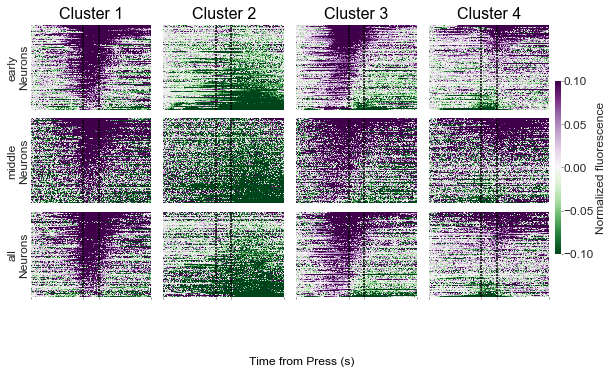

In [73]:
sessions = ['early', 'middle', 'all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=plt.get_cmap('PRGn_r'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size,
                                        infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from Press (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Ensemble Heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Ensemble Heatmaps.png'), format='PNG')


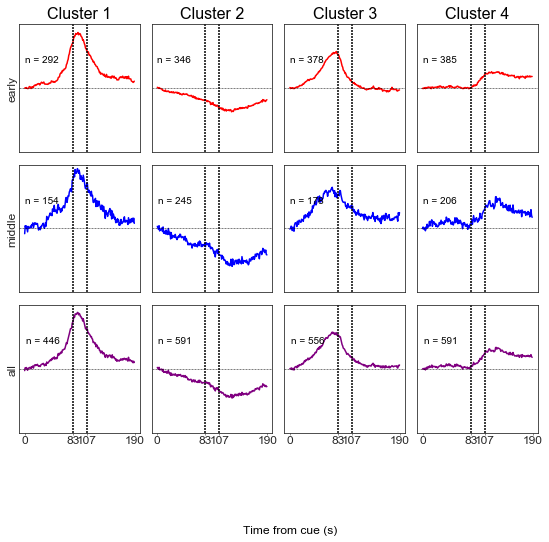

In [75]:
fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numroisincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.25, .25))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numroisincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Ensemble Lines.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - Extinction Ensemble Lines.png'), format='PNG')


# DECODING, START HERE IF YOU WANT A NEW DECODING ANALYSIS

In [36]:
###DECODING STARTS HERE
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import scipy.io as sio
import os
import subprocess
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

In [37]:
def binaryclassifier(y, X):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(SVC(), hyperparameters, cv=10)
    if np.any(np.isnan(X)):
        accuracy=np.nan
        print ('nan detected in single neuron! within ', fov)
    else:
        clf.fit(X, y)
        accuracy = clf.best_score_
    return accuracy

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'C': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        """y_pred = clf.predict(X)
        plt.plot(y,y_pred,'ko')"""
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

# DECODING - NO NEED TO RUN IF YOU'VE ALREADY SAVED DECODING RESULTS

In [17]:
###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons). Be sure your parameters below (~line 73) are what you want

groups = ['CueRein','CueRein'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 3 ###SET TO NUMBER OF CLUSTERS

# late_animals_of_interest = ['PNAC-JO1']

baseline = [1, 8]  ###These variables are for assigning neuronal data epochs
leverresponse = [pre_window_size-9, pre_window_size-1]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numroisincluster = np.nan*np.ones((numclusters,))

datadir=0
for group in groups:
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}
    classification_accuracy[group]['session'] = {}
    classification_accuracy[group]['session']['shuffled'] = {}
    classification_accuracy[group]['session']['unshuffled'] = {}
    
    if group == 'CueRein':
        animals_of_interest = early_animals_of_interest   
    if group == 'CueRein':
        animals_of_interest = middle_animals_of_interest
        if session_analysis_split_by_ensemble == ['Yes']:
            for c, cluster in enumerate(uniquelabels):
                classification_accuracy[group]['session']['shuffled'][c] = {}
                classification_accuracy[group]['session']['unshuffled'][c] = {}

    numneuronstillnow = 0
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(basedir, group, animal)))[1]
        for fov in sorted(fovs):
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'CueRein':
                cluster_id_list_fov = np.load(os.path.join(basedir, group, animal, fov, fov+'cluster_list_per_fov.npy'))
            temp1, temp2, activetrials, temp4, framerate = analyze_single_session(os.path.join(basedir, group, animal, fov),
                                                            window_size, pre_window_size)
            
            ###THIS SECTION DELETES ANY TRIALS WITH NANs
            for i in reversed(range(activetrials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(activetrials[i,:,:])):
                    activetrials = np.delete(activetrials, i, axis = 0)

            ###THIS SECTION ALIGNS DATA FOR DECODING        
            numtrials = activetrials.shape[0]
            numsamples = activetrials.shape[1]
            numneuronsinfov = activetrials.shape[2]

            baseline_active = np.nan*np.ones((numtrials,numneuronsinfov))
            response_active = np.nan*np.ones((numtrials,numneuronsinfov))

            activeflag = np.hstack((np.zeros((numtrials)), np.ones((numtrials))))
            
            for neuron in range(numneuronsinfov):
                baseline_active[:,neuron] = np.nanmean(activetrials[:,baseline[0]:baseline[1],neuron], axis=1)
                response_active[:,neuron] = np.nanmean(activetrials[:,leverresponse[0]:leverresponse[1],neuron], axis=1)
                
                ###CHANGE THESE VARIABLES TO ADJUST WHAT YOU ARE DECODING AND ENSURE IT ALIGNS WITH YOUR FLAGS
                neuralactivity_trialtype = np.vstack((baseline_active, response_active)) ###FOR COMPARING TRIAL TYPES
                
               ###TRIAL DECODING IN SINGLE NEURONS
                if session_analysis_split_by_ensemble == ['No'] and decoding == ['Neuron','Trial']:
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = \
                        binaryclassifier(activeflag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))

                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag,\
                                np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = \
                        shuffledresults
            
            ###TRIAL DECODING BY SESSION
            if session_analysis_split_by_ensemble == ['No'] and decoding == ['Session','Trial']:
                    classification_accuracy[group]['session']['unshuffled'][fov] = \
                        binaryclassifier(activeflag,neuralactivity_trialtype)                                                                           
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, neuralactivity_trialtype)
                    classification_accuracy[group]['session']['shuffled'][fov] = shuffledresults

            
            ###TRIAL DECODING BY SESSION & ENSEMBLE
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'LateAcq' and decoding == ['Session', 'Trial']:
                for c, cluster in enumerate(uniquelabels):
                    if np.count_nonzero(cluster_id_list_fov==c) > 1:
                        temp = np.squeeze(neuralactivity_trialtype[:, np.where(cluster_id_list_fov==cluster)])
                        classification_accuracy[group]['session']['unshuffled'][c][fov] = \
                            binaryclassifier(activeflag,temp)                                                             
                        shuffledresults = np.nan*np.ones((numshuffles,))
                        for shuffleid in range(numshuffles):
                            shuffled_flag = np.random.permutation(activeflag)
                            shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, temp)
                        classification_accuracy[group]['session']['shuffled'][c][fov] = shuffledresults

            numneuronstillnow += numneurons


('The behavioral file is longer than the imaging file. We discarded n = ', 1, ' active lever presses')
('and included n = ', 27, ' active lever presses')
('The behavioral file is longer than the imaging file. We discarded n = ', 13, ' active lever presses')
('and included n = ', 49, ' active lever presses')
('The behavioral file is longer than the imaging file. We discarded n = ', 1, ' active lever presses')
('and included n = ', 16, ' active lever presses')


IOError: [Errno 2] No such file or directory: 'C:\\Users\\OtisLab\\Dropbox\\2P Imaging Projects\\Beth\\PFC Self Admin\\CueRein\\LCDD-PGa1\\FOV1_tracked\\FOV1_trackedcluster_list_per_fov.npy'

In [201]:
# ###THIS SECTION IS TO SAVE DECODING DATA AS NUMPY ARRAYS
# save_results = 'Yes'
# variable_to_save = 'ActivePress'

# if save_results == 'Yes':
#     ### THIS SECTION IS FOR SAVING NEW DECODING RESULTS FOR SINGLE NEURON ANALYSES NOT YET SPLIT BY ENSEMBLE
#     if session_analysis_split_by_ensemble == ['No'] and decoding[0]=='Neuron':
#         for g, group in enumerate (groups):
#             unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])))[:,1]
#             shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])))[:,1]
#             stacked = np.vstack((unshuffled, shuffled))
#             np.save(os.path.join(basedir,'Results','Decoding',\
#                      'PNAC_SucroseSA_%s_%s_Decoding_Population_%s.npy'%(group,variable_to_save,decoding[0])),stacked)
            
#     ### THIS SECTION IS FOR SAVING NEW DECODING RESULTS FOR SESSION ANALYSES NOT SPLIT BY ENSEMBLE
#     elif session_analysis_split_by_ensemble == ['No'] and decoding[0]=='Session':
#         for g, group in enumerate (groups):
#             unshuffled = np.array(list(dict.items(classification_accuracy[group]['session']['unshuffled'])))[:,1]
#             shuffled = np.array(list(dict.items(classification_accuracy[group]['session']['shuffled'])))[:,1]
#             stacked = np.vstack((unshuffled, shuffled))
#             np.save(os.path.join(basedir,'Results','Decoding',\
#                      'PNAC_SucroseSA_%s_%s_Decoding_Population_%s.npy'%(group,variable_to_save,decoding[0])),stacked)
            
#     ### THIS SECTION IS FOR SAVING NEW DECODING RESULTS FOR SESSION ANALYSES SPLIT BY ENSEMBLE
#     elif session_analysis_split_by_ensemble == ['Yes']: 
#         for c, cluster in enumerate (uniquelabels):
#             unshuffled = np.array(list(dict.items(classification_accuracy[group]['session']['unshuffled'][c])))[:,1]
#             shuffled = np.array(list(dict.items(classification_accuracy[group]['session']['shuffled'][c])))[:,1]
#             stacked = np.vstack((unshuffled, shuffled))
#             np.save(os.path.join(basedir, 'Results', 'Decoding',\
#                     'PNAC_SucroseSA_%s_Decoding_Ensemble%s_Session.npy'%(variable_to_save,c)),stacked)
#     else:
#         print ('Data Not Saved')

# DECODING: FOR LOADING AND PLOTTING PREVIOUS DECODING RESULTS, START HERE

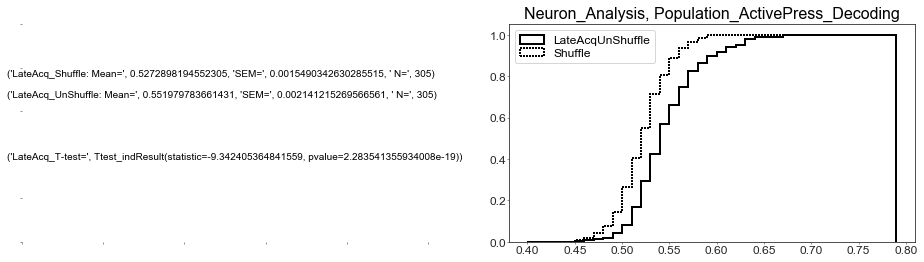

In [229]:
### DECODING CDF PLOTS FOR EARLY AND LATE DATA
analyze_by = 'Neuron' ###Session or Neuron
decodedir = os.path.join(basedir, 'Results', 'Decoding')
newlabels=np.load(os.path.join(earlybasedir, 'PFC HEROIN SA_clusterlabels_EMD-no-tracking_CUE.npy'))
variables_to_analyze = ['ActivePress']
groups = ['CueRein'] 
color = (['k'],['tab:red'])
bins = np.arange(0.4,0.8,0.01)
ls = ['--','solid']

d = {}
###THIS SECTION IS FOR LOADING AND PLOTTING SAVED POPULATION DECODING ARRAYS (BY NEURON OR SESSION)
for v, variable in enumerate (variables_to_analyze):
    d[variable] = {}
    all_shuffle_for_variable=[]
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    for g, group in enumerate(groups):
        d[variable][group] = {}
        d[variable][group] = np.array(np.load(os.path.join(decodedir, group,\
            'PNAC_SucroseSA_%s_%s_Decoding_Population_%s.npy'%(group,variable,analyze_by)),\
            allow_pickle = True).astype(float))
        temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
        temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])
        for i in range(len(temp_unshuffle)):
            if np.isfinite(temp_unshuffle[i]):
                temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
        for i in range(len(temp_shuffle)):
            if np.isfinite(temp_shuffle[i]):
                temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
        plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
            label = ['%sUnShuffle'%(group)], histtype='step',\
            linestyle = ('-'), bins = bins, color = color[g], linewidth=2)
        if analyze_by == 'Session':
            plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
            label = ['%sShuffle'%(group)], histtype='step',\
            linestyle = ('--'), bins = bins, color = color[g], linewidth=2)
        elif analyze_by == 'Neuron':
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
            if g == len(groups)-1:
                plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
                    label = ['Shuffle','%sUnhuffle'%(group)], histtype='step',\
                    linestyle = ('--'), bins = bins, color = 'k', linewidth=2)
        
        plt.text(-0.15, (0.8-g*.2), ('%s_Shuffle: Mean='%(group), np.mean(temp_shuffle_nonans), \
            'SEM=', stats.sem(temp_shuffle_nonans), ' N=',len(temp_shuffle_nonans)))
        plt.text(-0.15, 0.7-g*.2, ('%s_UnShuffle: Mean='%(group), np.mean(temp_unshuffle_nonans), \
            'SEM=', stats.sem(temp_unshuffle_nonans), ' N=',len(temp_unshuffle_nonans)))
        plt.text(-0.15, 0.4-g*.1, ('%s_T-test='%(group), stats.ttest_ind(temp_shuffle_nonans,\
            temp_unshuffle_nonans, equal_var=False)))

    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)

    plt.legend(loc=2)
    plt.title('%s_Analysis, Population_%s_Decoding'%(analyze_by, variable))
    
#     plt.savefig(os.path.join(decodedir, 'PNAC_SucroseSA - Population Decoding_%s_%s.PDF'\
#         %(variable, analyze_by)), format = 'PDF')

    plt.show()

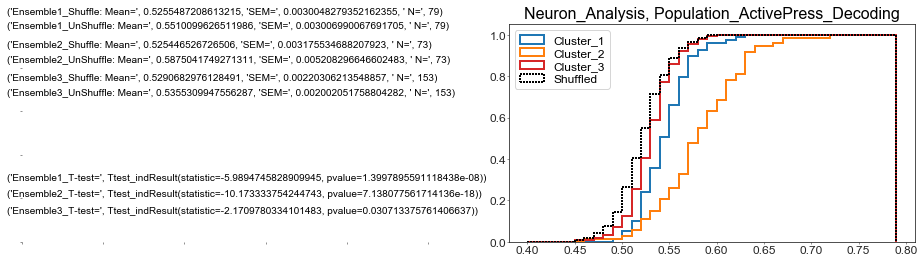

In [230]:
### DECODING CDF PLOTS FOR EACH ENSEMBLE
analyze_by = 'Neuron' ###Session or Neuron
ensembledir = os.path.join(basedir, 'Results', 'Decoding', 'DecodingEnsembles')
decodedir = os.path.join(basedir, 'Results', 'Decoding')
variables_to_analyze = ['ActivePress']
numclusters = 3 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)
color = (['tab:blue'],['tab:orange'],['tab:red'])

bins = np.arange(0.4,0.8,0.01)

d = {}

if analyze_by == 'Neuron':
    for v, variable in enumerate(variables_to_analyze):
        d[variable]={}
        all_shuffle_for_variable = []
        fig, ax = plt.subplots(1, 2, figsize = (16,4))
        for c, cluster in enumerate(uniquelabels): 
            d[variable][cluster]= {}
            temp_array = np.load(os.path.join(decodedir,'CueRein',\
                'PNAC_SucroseSA_LateAcq_%s_Decoding_Population_%s.npy'%(variable, analyze_by)),\
                allow_pickle=True).astype(float)
            d[variable][cluster] = np.squeeze(temp_array[:, np.where(newlabels==c)])
            plt.hist((d[variable][cluster][0]), density=True, cumulative=True,\
                    label = ['Cluster_%s'%(c+1)], histtype='step', linestyle = '-',\
                    color = color[c], bins = bins, linewidth=2)
#             plt.hist((d[variable][cluster][1]), density=True, cumulative=True,\
#                     label = ['Cluster_%s'%(c+1)], histtype='step', linestyle = '--',\
#                     color = color[c], bins = bins, linewidth=2)
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][c][1])

            plt.text(-0.15, (1.1-c*.16), ('Ensemble%s_Shuffle: Mean='%(cluster+1), np.mean(d[variable][cluster][1]), \
                'SEM=', stats.sem(d[variable][c][1]), ' N=',len(d[variable][c][1])))
            plt.text(-0.15, 1.03-c*.16, ('Ensemble%s_UnShuffle: Mean='%(cluster+1), np.mean(d[variable][cluster][0]), \
                'SEM=', stats.sem(d[variable][c][0]), ' N=',len(d[variable][c][0])))
            plt.text(-0.15, 0.3-c*.08, ('Ensemble%s_T-test='%(cluster+1), stats.ttest_ind(d[variable][cluster][1],\
                d[variable][cluster][0], equal_var=False)))
            
            if c == len(uniquelabels)-1:
                plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                    label = ['Shuffled'], histtype='step', linestyle = '--',\
                    color = ['k'], bins = bins, linewidth=2)

            ax[0].set_xticklabels([])
            ax[0].set_yticklabels([])
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['left'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)

            plt.legend(loc=2)
            plt.title('%s_Analysis, Population_%s_Decoding'%(analyze_by, variable))

        plt.savefig(os.path.join(decodedir, 'PNAC_SucroseSA - Ensemble Decoding_%s_%s.PDF'\
            %(variable, analyze_by)), format = 'PDF')
        plt.legend(loc=2)
        plt.show()

        
if analyze_by == 'Session':
    for v, variable in enumerate(variables_to_analyze):
        d[variable]={}
        all_shuffle_for_variable = []
        fig, ax = plt.subplots(1, 2, figsize = (16,4))
        for c, cluster in enumerate(uniquelabels): 
            d[variable][cluster]= {}
            d[variable][cluster] = np.load(os.path.join(ensembledir,\
                'PNAC_SucroseSA_%s_Decoding_Ensemble%s_%s.npy'%(variable, cluster, analyze_by)),\
                allow_pickle=True).astype(float)
            plt.hist((d[variable][cluster][0]), density=True, cumulative=True,\
                        label = ['Cluster_%s'%(c+1)], histtype='step', linestyle = '-',\
                        color = color[c], bins = bins, linewidth=2)
            plt.hist((d[variable][cluster][1]), density=True, cumulative=True,\
                        label = ['Cluster_%s'%(c+1)], histtype='step', linestyle = '--',\
                        color = color[c], bins = bins, linewidth=2)
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][c][1])
            if c == len(uniquelabels)-1:
#                 plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
#                     label = ['Shuffled'], histtype='step', linestyle = '--',\
#                     color = ['k'], bins = bins, linewidth=2)
                for c, cluster in enumerate(uniquelabels):
                    plt.text(bins[0]-0.6, (1.1-c*.16), ('Ensemble%s_Shuffle: Mean='%(cluster+1), np.mean(d[variable][cluster][1]), \
                        'SEM=', stats.sem(d[variable][cluster][1]), ' N=',len(d[variable][cluster][1])))
                    plt.text(bins[0]-0.6, 1.03-c*.16, ('Ensemble%s_UnShuffle: Mean='%(cluster+1), np.mean(d[variable][cluster][0]), \
                        'SEM=', stats.sem(d[variable][cluster][0]), ' N=',len(d[variable][cluster][0])))
                    plt.text(bins[0]-0.6, 0.3-c*.08, ('Ensemble%s_T-test='%(cluster+1), stats.ttest_ind(all_shuffle_for_variable,\
                        d[variable][cluster][0], equal_var=False)))
        
                    ax[0].set_xticklabels([])
                    ax[0].set_yticklabels([])
                    ax[0].spines['top'].set_visible(False)
                    ax[0].spines['right'].set_visible(False)
                    ax[0].spines['left'].set_visible(False)
                    ax[0].spines['bottom'].set_visible(False)

                    plt.legend(loc=2)
                
        plt.title('%s_Analysis, Population_%s_Decoding'%(analyze_by, variable))

        plt.savefig(os.path.join(decodedir, 'PNAC_SucroseSA - Ensemble Decoding_%s_%s.PDF'\
            %(variable, analyze_by)), format = 'PDF')

        plt.show()

In [180]:
def calculate_t(x, y):
    Sp= np.sqrt((np.nanstd(x)**2 + np.nanstd(y)**2)/2)
    denominator = Sp*(np.sqrt(2/len(x)))
    numerator = np.nanmean(x) - np.nanmean(y)
    t = numerator/denominator
    return t

# THIS SECTION IS FOR PLOTTING DECODING HEATMAPS

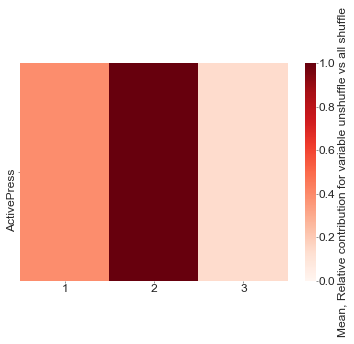

In [194]:
### DECODING HEATMAPS SPLIT BY ENSEMBLE
analyze_by = 'Neuron' ###Session or Neuron
plot_as = ['mean'] ###Select 't-value' or 'mean'
normalize = ['Yes'] ###Select Yes or No; if 'No' plots as raw values
delete_low_tvalues = ['Yes'] ###Select Yes or No; based on t-value
min_t_value = 1 ###Select min t-value if above is 'Yes"'
ensembledir = os.path.join(basedir, 'Results', 'Decoding', 'DecodingEnsembles')
decodedir = os.path.join(basedir, 'Results', 'Decoding')
variables_to_analyze = ['ActivePress']
numclusters = 3 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

d = {}
temp_append = []

if analyze_by == 'Neuron':
    for v, variable in enumerate(variables_to_analyze):
        d[variable]={}
        all_shuffle_for_variable = []
        for c, cluster in enumerate(uniquelabels): 
            d[variable][cluster]= {}
            temp_array = np.load(os.path.join(decodedir,'LateAcq',
            'PNAC_SucroseSA_LateAcq_%s_Decoding_Population_%s.npy'%(variable, analyze_by)),\
            allow_pickle=True).astype(float)
            d[variable][cluster] = np.squeeze(temp_array[:, np.where(newlabels==c)])
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][c][1])
            if c == len(uniquelabels)-1:
                for c, cluster in enumerate(uniquelabels):
                    temp_t = calculate_t(d[variable][c][0], all_shuffle_for_variable)
                    temp_mean = np.mean(d[variable][c][0])-np.mean(all_shuffle_for_variable)
                    if delete_low_tvalues == ['Yes']:
                        if temp_t < min_t_value:
                            temp_t, temp_mean = [1,0]
                    if plot_as == ['t-value']:
                        temp_append = np.append(temp_append,temp_t) 
                    elif plot_as == ['mean']:
                        temp_append = np.append(temp_append, temp_mean)


if analyze_by == 'Session':
    for v, variable in enumerate(variables_to_analyze):
        d[variable]={}
        all_shuffle_for_variable = []
        for c, cluster in enumerate(uniquelabels):
            d[variable][cluster]= {}
            d[variable][cluster]= np.load(os.path.join(ensembledir,\
                'PNAC_Sucrose_%s_Decoding_Ensemble%s_Session.npy'%(variable, cluster)),\
                allow_pickle=True).astype(float)
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][c][1])
            if c == len(uniquelabels)-1:
                for c, cluster in enumerate(uniquelabels):
                    temp_t = calculate_t(d[variable][c][0], all_shuffle_for_variable)
                    temp_mean = np.mean(d[variable][c][0])-np.mean(all_shuffle_for_variable)
                    if delete_low_tvalues == ['Yes']:
                        if temp_t < min_t_value:
                            temp_t, temp_mean = [1,0]
                    if plot_as == ['t-value']:
                        temp_append = np.append(temp_append,temp_t) 
                    elif plot_as == ['mean']:
                        temp_append = np.append(temp_append, temp_mean)
                        
heatmap_array = np.reshape(temp_append,(len(variables_to_analyze),len(uniquelabels)))

if normalize == ['Yes']:
    for v, variable in enumerate(variables_to_analyze):
        max_for_variable = np.max(heatmap_array[v,:])
        heatmap_array[v,:] = heatmap_array[v,:]/max_for_variable
        
# ###THIS SECTION PLOTS THE HEATMAP DATA 
cmax = 1
cmin = 0
y_labels = variables_to_analyze
x_labels = ['1', '2', '3']
fig = sns.heatmap(heatmap_array, vmax = cmax, vmin = cmin, linewidth=0,cmap=plt.get_cmap('Reds'),
           cbar_kws={'label': 'Mean, Relative contribution for variable unshuffle vs all shuffle'}, yticklabels=(y_labels), xticklabels=(x_labels))
figure = fig.get_figure() 

# figure.savefig(os.path.join(basedir, 'Results','Decoding', 'PFC Pavlovian - Decoding Heatmap Ensemble.png'), format='png')
# figure.savefig(os.path.join(basedir, 'Results','Decoding', 'PFC Pavlovian - Decoding Heatmap Ensemble %s.PDF'%(analyze_by)), format='PDF')

